# Research Planning Agent

Creates a structured plan to get the information for the topic in user prompt

In [1]:
!pip install langgraph
!pip install langchain_openai
!pip install python-dotenv
!pip install langchain_core
!pip install IPython
!pip install langchain-groq

In [2]:
from typing import Dict, TypedDict, Optional, List, Any, Annotated
from langgraph.graph import START, StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from google.colab import userdata
from langchain_groq import ChatGroq
from groq import Groq

from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os, re

### Load Secrets

In [3]:
GROQ_API_KEY = userdata.get('GROQ_API_KEY')
os.environ['GROQ_API_KEY'] = GROQ_API_KEY

llm = "llama-3.1-8b-instant"
chat_groq_llm = ChatGroq(model_name=llm, groq_api_key=GROQ_API_KEY)

In [11]:
research_planning_message = """
You are a Research Planning Agent. Your goal is to create a structured plan to get the necessary information for a given research topic provided by the user.

Responsibilities:
- Understand the user's research topic.
- Break down the research topic into key questions or areas to investigate.
- Structure the research process into a clear, step-by-step plan.
- Highlight important aspects or keywords from the prompt that should be prioritized in the research.

Behavior:
- Analyze the input prompt carefully to grasp the core research need.
- Present the plan in a clear, organized, and easy-to-follow format.
- Be concise and focused on the planning aspect, not the research execution itself.

Outputs:
- A structured research plan, potentially including:
    - A breakdown of the topic into sub-questions.
    - Suggested keywords for searching
    - Key points from the original prompt to keep in mind.
"""

In [12]:
@tool
def extract_info(query: str):
    """
    Understands the user's input/query and breaks it down into the historical topic and time period, returning.

    Parameters:
        str: The user's historical query.

    Returns:
        str: A formatted string containing the extracted information.
    """
    # Use the LLM to extract the historical topic and time period from the query
    # Instruct the LLM to format the output as a simple string
    prompt = f"""
    From the following historical research query, extract the main historical topic, the specific time period, location, and group of people involved.
    If a value is not present in the query, use the general value linked to the topic.

    Query: {query}

    Format the output as a single string like this:
    Topic: [Extracted Topic] | Time Period: [Extracted Time Period] | Location: [Extracted Location] | Group of People involved: [Extracted Group of People]
    """
    response = chat_groq_llm.invoke(prompt)
    return response.content


@tool
def generate_plan(info_string: str):
    """
    Takes a formatted string from extract_info to plan the research.

    Args:
        str: Expected format: "Topic: [...] | Time Period: [...] | Location: [...] | Group of People involved: [...]"

    Returns:
        str: A structured research plan based on the extracted information.
    """
    # Parse the information from the formatted string
    info = {}
    for part in info_string.split(" | "):
        if ":" in part:
            key, value = part.split(":", 1)
            info[key.strip()] = value.strip()

    # Get the extracted information, defaulting to "N/A" if parsing fails or key is missing
    topic = info.get("Topic", "N/A")
    time_period = info.get("Time Period", "N/A")
    location = info.get("Location", "N/A")
    group_involved = info.get("Group of People involved", "N/A")

    # Use the LLM to generate a research plan based on the extracted information
    prompt = f"""
    Based on the following historical information:

    Topic: {topic}
    Time Period: {time_period}
    Location: {location}
    Group of People involved: {group_involved}

    Create a plan that includes:
    - Five specific research questions to answer based on the topic, time period, location, and group involved.
    - Ten suggested keywords for searching the historical topic
    -  and search strategies.

    Format the output like this:
    Research Questions:
      questuion1
      question2
      question3
      question4
      question5

    Suggested Keywords:
      keyword1
      keyword2
      keyword3
      keyword4
      keyword5
      keyword6
      keyword7
      keyword8
      keyword9
      keyword10
    """

    response = chat_groq_llm.invoke(prompt)
    return response.content

In [13]:
research_planning_agent = create_react_agent(
    model=chat_groq_llm,
    tools=[extract_info, generate_plan],
    prompt=research_planning_message,
    name="research_planning_agent"
)

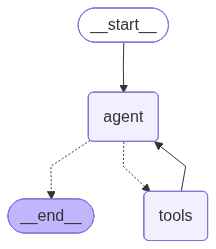

In [14]:
display(Image(research_planning_agent.get_graph().draw_mermaid_png()))

In [15]:
# Example 1
query = "Research the causes and consequences of the French Revolution."

response = research_planning_agent.invoke({"messages": [{"role": "user", "content": query}]})
for message in response['messages']:
    message.pretty_print()



================================ Human Message =================================

Research the causes and consequences of the French Revolution.
================================== Ai Message ==================================
Name: research_planning_agent
Tool Calls:
  extract_info (rv5yvqamk)
 Call ID: rv5yvqamk
  Args:
    query: Research the causes and consequences of the French Revolution.
================================= Tool Message =================================
Name: extract_info

Topic: The French Revolution | Time Period: Late 18th century (Specifically 1789-1799) | Location: France | Group of People involved: French people and the aristocracy.
================================== Ai Message ==================================
Name: research_planning_agent
Tool Calls:
  generate_plan (n0pj3ss5d)
 Call ID: n0pj3ss5d
  Args:
    info_string: Topic: The French Revolution | Time Period: Late 18th century (Specifically 1789-1799) | Location: France | Group of People involved: Fre

In [16]:
# Example 2
query_detailed = """
Research the impact of the Black Death on European society in the 14th century.
Focus on:
- What were the immediate social and economic effects?
- How did it influence labor relations and class structures?
- What were the long-term demographic changes?
- How did religious beliefs and practices change?
"""

response = research_planning_agent.invoke({"messages": [{"role": "user", "content": query_detailed}]})
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================


Research the impact of the Black Death on European society in the 14th century.
Focus on:
- What were the immediate social and economic effects?
- How did it influence labor relations and class structures?
- What were the long-term demographic changes?
- How did religious beliefs and practices change?

================================== Ai Message ==================================
Name: research_planning_agent
Tool Calls:
  extract_info (0mabqckex)
 Call ID: 0mabqckex
  Args:
    query: Research the impact of the Black Death on European society in the 14th century. Focus on: - What were the immediate social and economic effects? - How did it influence labor relations and class structures? - What were the long-term demographic changes? - How did religious beliefs and practices change?
  generate_plan (x95gf3aqk)
 Call ID: x95gf3aqk
  Args:
    info_string: Topic: Impact of the Black Death on European soc

In [17]:
# Example 3
query = "Look into the industrial revolution"

response = research_planning_agent.invoke({"messages": [{"role": "user", "content": query}]})
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

Look into the industrial revolution
================================== Ai Message ==================================
Name: research_planning_agent
Tool Calls:
  extract_info (901bbwt1j)
 Call ID: 901bbwt1j
  Args:
    query: industrial revolution
  generate_plan (y7z7q32ct)
 Call ID: y7z7q32ct
  Args:
    info_string: Topic: Industrial Revolution | Time Period: 18th-19th century | Location: Europe and North America | Group of People involved: Inventors, Industrialists, Workers
================================= Tool Message =================================
Name: extract_info

Topic: Industrial Revolution | Time Period: 18th-19th century | Location: Europe and North America | Group of People involved: Industrial workers and entrepreneurs
================================= Tool Message =================================
Name: generate_plan

**Research Plan: Industrial Revolution in Europe and North America (1